* Tải thư viện

In [ ]:
!pip3 install pandas
!pip3 install dask
!pip3 install scikit-learn
!pip3 install seaborn
!pip3 install matplotlib
!pip3 install gensim
!pip3 install nltk
!pip3 install pyarrow

1. Đọc dữ liệu

In [ ]:
import pandas as pd

# Đọc file CSV
columns = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv("dataset_tweet.csv", encoding="ISO-8859-1", names=columns)

# Xem 5 dòng đầu
print(df.head())

   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


- Vì tài nguyên máy hạn chế nên sẽ sử dụng 100000 dòng trong 1.6m dòng

In [2]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df[:500000]

2. Xử lý dữ liệu

In [3]:
import re
import nltk
from nltk.corpus import stopwords


nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Xóa URL
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Xóa ký tự đặc biệt
    text = text.lower()
    return " ".join([word for word in text.split() if word not in stop_words])

df["cleaned_text"] = df["text"].apply(clean_text)
print(df[["user", "cleaned_text"]].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HoangVi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


              user                                       cleaned_text
0  LaLaLindsey0609                         chrishasboobs ahhh hope ok
1      sexygrneyes                 misstoriblack cool tweet apps razr
2       sammydearr  tiannachaos know family drama lamehey next tim...
3      Lamb_Leanne  school email wont open geography stuff revise ...
4      yogicerdito                              upper airways problem


3. Phân tích hành vi người dùng

3.1. Hành vi và phân loại hành vi 
- Dùng nhãn "target" để phân loại: tiêu cực(0), tích cực(4)

In [4]:
behavior = df.groupby("user")["target"].value_counts().unstack(fill_value=0)
behavior.columns = ["negative", "positive"]
print(behavior.head())
print()
print(behavior.sum())  # Tổng số tweet tiêu cực/tích cực

                 negative  positive
user                               
000catnap000            1         1
000matthewkelly         0         1
000yea000               0         1
001BabyGirl             0         1
001trish                0         1

negative    249375
positive    250625
dtype: int64


3.2. Phát hiện quan tâm dựa trên hành vi
- Dùng TF-IDF để tìm từ khóa quan trọng trong tweet của mỗi người dùng

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000)

user_counts = df["user"].value_counts()
active_users = user_counts[user_counts >= 5].index
df_active = df[df["user"].isin(active_users)]
df_active = df_active.dropna(subset=["cleaned_text"])
#print("Số dòng trong df_active sau khi loại NaN:", len(df_active))
tfidf_matrix = tfidf.fit_transform(df_active["cleaned_text"])

feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
df_tfidf = pd.concat([df[["user"]], tfidf_df], axis=1)
print(df_tfidf.head())

              user  able  absolutely  account  actually  add  afraid  \
0  LaLaLindsey0609   0.0         0.0      0.0       0.0  0.0     0.0   
1      sexygrneyes   0.0         0.0      0.0       0.0  0.0     0.0   
2       sammydearr   0.0         0.0      0.0       0.0  0.0     0.0   
3      Lamb_Leanne   0.0         0.0      0.0       0.0  0.0     0.0   
4      yogicerdito   0.0         0.0      0.0       0.0  0.0     0.0   

   afternoon  ages  ago  ...  youll  young  youngq  youre  youtube  youve  \
0        0.0   0.0  0.0  ...    0.0    0.0     0.0    0.0      0.0    0.0   
1        0.0   0.0  0.0  ...    0.0    0.0     0.0    0.0      0.0    0.0   
2        0.0   0.0  0.0  ...    0.0    0.0     0.0    0.0      0.0    0.0   
3        0.0   0.0  0.0  ...    0.0    0.0     0.0    0.0      0.0    0.0   
4        0.0   0.0  0.0  ...    0.0    0.0     0.0    0.0      0.0    0.0   

    yr  yum  yummy  yup  
0  0.0  0.0    0.0  0.0  
1  0.0  0.0    0.0  0.0  
2  0.0  0.0    0.0  0.0  


- Top 10 từ khóa phổ biến

In [6]:
print(pd.Series(tfidf.vocabulary_).sort_values(ascending=False).head(10))

yup        999
yummy      998
yum        997
yr         996
youve      995
youtube    994
youre      993
youngq     992
young      991
youll      990
dtype: int32


3.3. Cộng đồng người dùng
- Dùng K-Means để nhóm người dùng dựa theo nội dung tweet

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=42)
df_active["cluster"] = kmeans.fit_predict(tfidf_matrix)
print(df_active.groupby("cluster")["user"].nunique())

cluster
0     1747
1    13203
2     5453
3     6392
4     3117
5     3873
6     4172
Name: user, dtype: int64


- Đánh giá chất lượng cụm

In [65]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score

# Giảm chiều dữ liệu TF-IDF
svd = TruncatedSVD(n_components=50, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# Phân cụm trên dữ liệu đã giảm chiều
kmeans = KMeans(n_clusters=7, random_state=42)
df_active["cluster"] = kmeans.fit_predict(tfidf_reduced)

# Đánh giá lại
score = silhouette_score(tfidf_reduced, df_active["cluster"])
print(f"Silhouette Score sau khi giảm chiều: {score}")

Silhouette Score sau khi giảm chiều: 0.15223015366357862


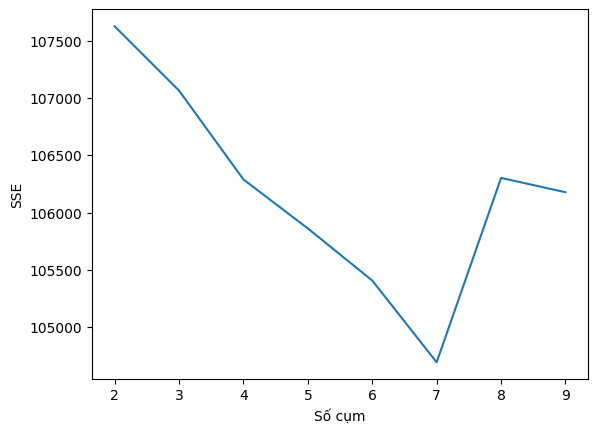

In [13]:
import matplotlib.pyplot as plt
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    sse.append(kmeans.inertia_)
plt.plot(range(2, 10), sse)
plt.xlabel("Số cụm")
plt.ylabel("SSE")
plt.show()

4. Xây dựng mô hình người dùng theo hành vi

4.1. Mô hình biểu diễn và vector trọng số
- Tạo vector TF-IDF trung bình cho mỗi người dùng

In [29]:
user_tfidf = df_tfidf[df_tfidf["user"].isin(active_users)].groupby("user")[feature_names].mean()
user_tfidf = user_tfidf.dropna()
print(user_tfidf.head())
print(user_tfidf.mean().sort_values(ascending=False).head(10))

                 able  absolutely  account  actually  add  afraid  afternoon  \
user                                                                           
007peter          0.0         0.0      0.0       0.0  0.0     0.0        0.0   
11chiqa11         0.0         0.0      0.0       0.0  0.0     0.0        0.0   
12gaBrowningGal   0.0         0.0      0.0       0.0  0.0     0.0        0.0   
15Stepz           0.0         0.0      0.0       0.0  0.0     0.0        0.0   
16_MileyCyrus     0.0         0.0      0.0       0.0  0.0     0.0        0.0   

                 ages  ago  agree  ...  youll  young  youngq     youre  \
user                               ...                                   
007peter          0.0  0.0    0.0  ...    0.0    0.0     0.0  0.000000   
11chiqa11         0.0  0.0    0.0  ...    0.0    0.0     0.0  0.000000   
12gaBrowningGal   0.0  0.0    0.0  ...    0.0    0.0     0.0  0.000000   
15Stepz           0.0  0.0    0.0  ...    0.0    0.0     0.0  0.00000

4.2. Độ tương tự giữa 2 người dùng
- Tính Cosine Similarity giữa các vector người dùng

In [30]:
import dask.array as da
from sklearn.metrics.pairwise import cosine_similarity

user_tfidf_dask = da.from_array(user_tfidf.values, chunks=(1000, 1000))
similarity = cosine_similarity(user_tfidf_dask[:1000].compute())
similarity_df = pd.DataFrame(similarity, index=user_tfidf.index[:1000], columns=user_tfidf.index[:1000])
print(similarity_df.iloc[:10, :10])

user             007peter  11chiqa11  12gaBrowningGal   15Stepz  \
user                                                              
007peter              1.0        0.0         0.000000  0.000000   
11chiqa11             0.0        1.0         0.000000  0.000000   
12gaBrowningGal       0.0        0.0         1.000000  0.155943   
15Stepz               0.0        0.0         0.155943  1.000000   
16_MileyCyrus         0.0        0.0         0.020624  0.044559   
18percentgrey         0.0        0.0         0.000000  0.097305   
19MarkAttack          0.0        0.0         0.000000  0.000000   
19c816tf9227          0.0        0.0         0.034815  0.144015   
19fischi75            0.0        0.0         0.000000  0.083429   
1ChazD                0.0        0.0         0.000000  0.155591   

user             16_MileyCyrus  18percentgrey  19MarkAttack  19c816tf9227  \
user                                                                        
007peter              0.000000       0.00

5. Dự đoán sự quan tâm theo mô hình hành vi

5.1. Biểu diễn mô hình hành vi theo không gian chủ đề
- Dùng LDA để phân tích chủ đề từ tweet

In [34]:
df = df[:100000]

In [ ]:
from gensim import corpora
from gensim.models import LdaModel

df_sample = df.sample(n=100000, random_state=42)

tokenized_texts = [text.split() for text in df["cleaned_text"]]
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
lda_model = LdaModel(corpus, num_topics=7, id2word=dictionary, passes=10)

topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.007*"amp" + 0.007*"listening" + 0.006*"eating" + 0.006*"lunch" + 0.005*"ha" + 0.005*"music" + 0.005*"id" + 0.005*"leaving" + 0.005*"win" + 0.005*"ice"')
(1, '0.030*"twitter" + 0.020*"thanks" + 0.015*"thank" + 0.014*"looking" + 0.010*"hey" + 0.009*"tweet" + 0.009*"friends" + 0.009*"new" + 0.008*"check" + 0.007*"playing"')
(2, '0.044*"day" + 0.019*"work" + 0.012*"getting" + 0.010*"ready" + 0.010*"yay" + 0.008*"back" + 0.008*"way" + 0.008*"great" + 0.008*"today" + 0.008*"happy"')
(3, '0.024*"love" + 0.021*"like" + 0.020*"lol" + 0.020*"know" + 0.020*"u" + 0.018*"im" + 0.017*"dont" + 0.011*"thats" + 0.011*"haha" + 0.010*"wish"')
(4, '0.014*"watching" + 0.011*"watch" + 0.009*"movie" + 0.008*"going" + 0.008*"sun" + 0.008*"party" + 0.008*"rain" + 0.007*"weather" + 0.007*"amp" + 0.007*"miss"')
(5, '0.038*"im" + 0.024*"go" + 0.022*"cant" + 0.019*"going" + 0.016*"get" + 0.016*"good" + 0.014*"work" + 0.012*"back" + 0.011*"today" + 0.011*"home"')
(6, '0.016*"got" + 0.016*"last" + 0.015*"time

5.2. Xác định chủ đề quan tâm
- Gán chủ đề cho mỗi người dùng dựa trên tweet của họ.

In [36]:
#Gán chủ đề nổi bật cho mỗi tweet với các chủ đề khác nhau (dùng mode)
def get_dominant_topic(doc):
    topic_dist = lda_model[doc]
    return max(topic_dist, key=lambda x: x[1])[0] if topic_dist else None

df["dominant_topic"] = [get_dominant_topic(doc) for doc in corpus]
user_topics = df.groupby("user")["dominant_topic"].agg(lambda x: x.mode()[0] if not x.empty else None)
print(user_topics.head())

user
000yea000        3
007_Chris_007    6
007peter         4
00blondey00      1
00kate00         4
Name: dominant_topic, dtype: int64


In [38]:
#Tính trung bình phân phối chủ đề
import numpy as np
df["topic_dist"] = [dict(lda_model[doc]) for doc in corpus]
def aggregate_topic_dist(group):
    dists = group["topic_dist"].tolist()
    aggregated = {i: np.mean([d.get(i, 0) for d in dists]) for i in range(5)}
    return pd.Series(aggregated)
user_topics_arr = df.groupby("user").apply(aggregate_topic_dist)
print(user_topics_arr.head())

                      0         1         2         3         4
user                                                           
000yea000      0.228470  0.028699  0.028631  0.428349  0.028700
007_Chris_007  0.012054  0.297843  0.012000  0.012059  0.311994
007peter       0.020264  0.020244  0.164863  0.329446  0.424603
00blondey00    0.230201  0.431687  0.028769  0.028784  0.223021
00kate00       0.013753  0.013760  0.105128  0.013787  0.342193


C:\Users\HoangVi\AppData\Local\Temp\ipykernel_15008\1832139242.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_topics_arr = df.groupby("user").apply(aggregate_topic_dist)


5.3. Độ tương tự theo chủ đề
- Tính Cosine Similarity trên phân phối chủ đề của người dùng

In [40]:
import dask.dataframe as dd
import dask.array as da
from gensim.models import LdaMulticore
from gensim import corpora
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [41]:
# Lấy mẫu 10,000 người dùng
unique_users = df["user"].unique()
sample_users = np.random.choice(unique_users, size=10000, replace=False)
df_sample = df[df["user"].isin(sample_users)].copy()

In [42]:
# Tạo corpus và huấn luyện LDA
tokenized_texts = [text.split() for text in df_sample["cleaned_text"]]
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
lda_model = LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=5, workers=4)

In [43]:
# Tính phân phối chủ đề
df_sample["topic_dist"] = [dict(lda_model[doc]) for doc in corpus]

# Kiểm tra dữ liệu
print("Kiểu dữ liệu topic_dist:", df_sample["topic_dist"].dtype)
print("5 giá trị đầu tiên:")
print(df_sample["topic_dist"].head())

Kiểu dữ liệu topic_dist: object
5 giá trị đầu tiên:
4     {0: 0.41073793, 1: 0.050251354, 2: 0.43865052,...
6     {0: 0.051309902, 1: 0.050588947, 2: 0.79657954...
12    {0: 0.034704912, 1: 0.03432126, 2: 0.033951815...
22    {0: 0.0127127515, 1: 0.012712403, 2: 0.0128730...
25    {0: 0.051096182, 1: 0.05077327, 2: 0.050881036...
Name: topic_dist, dtype: object


In [44]:
# Gộp phân phối chủ đề theo user trong Pandas
def aggregate_topic_dist(group):
    dists = group["topic_dist"].tolist()
    aggregated = {}
    for topic in range(5):
        aggregated[topic] = np.mean([d.get(topic, 0) for d in dists])
    return pd.Series(aggregated)

user_topic_df = df_sample.groupby("user").apply(aggregate_topic_dist)
print("user_topic_df (5 dòng đầu):")
print(user_topic_df.head())

user_topic_df (5 dòng đầu):
                      0         1         2         3         4
user                                                           
000yea000      0.040319  0.040525  0.040904  0.040728  0.837525
007peter       0.022773  0.022492  0.022628  0.022658  0.909450
03hokie        0.050802  0.795733  0.050808  0.051508  0.051149
08vintagelove  0.050673  0.051504  0.796382  0.051320  0.050120
094459         0.022996  0.022736  0.023189  0.022983  0.908096


C:\Users\HoangVi\AppData\Local\Temp\ipykernel_15008\2221721415.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_topic_df = df_sample.groupby("user").apply(aggregate_topic_dist)


In [45]:
# Tính Cosine Similarity với Dask Array
topic_array = da.from_array(user_topic_df.values, chunks=(1000, 5))
similarity = cosine_similarity(topic_array.compute())
similarity_df = pd.DataFrame(similarity, index=user_topic_df.index, columns=user_topic_df.index)
print("Ma trận độ tương tự (5x5):")
print(similarity_df.iloc[:5, :5])

Ma trận độ tương tự (5x5):
user           000yea000  007peter   03hokie  08vintagelove    094459
user                                                                 
000yea000       1.000000  0.998898  0.120446       0.119561  0.998936
007peter        0.998898  1.000000  0.092931       0.091752  1.000000
03hokie         0.120446  0.092931  1.000000       0.138529  0.093315
08vintagelove   0.119561  0.091752  0.138529       1.000000  0.092460
094459          0.998936  1.000000  0.093315       0.092460  1.000000


In [47]:
kmeans = KMeans(n_clusters=5, random_state=42)
user_topic_df["cluster"] = kmeans.fit_predict(user_topic_df)
score = silhouette_score(user_topic_df, user_topic_df["cluster"])
print(f"Silhouette Score: {score}")

Silhouette Score: 0.8147868758557115


6. Đánh giá và trực quan hóa

6.1. Đánh giá

In [53]:
from sklearn.metrics import silhouette_score

user_topics = df_sample.groupby("user").apply(aggregate_topic_dist)

# Phân cụm theo chủ đề
kmeans = KMeans(n_clusters=5, random_state=42)
user_topics["cluster"] = kmeans.fit_predict(user_topics)
print("Phân bố cụm:")
print(user_topics["cluster"].value_counts())

# Đánh giá bằng Silhouette Score
silhouette = silhouette_score(user_topics.drop("cluster", axis=1), user_topics["cluster"])
print(f"Silhouette Score: {silhouette}")

C:\Users\HoangVi\AppData\Local\Temp\ipykernel_15008\827413028.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_topics = df_sample.groupby("user").apply(aggregate_topic_dist)


Phân bố cụm:
cluster
0    2623
4    2080
1    2032
2    1703
3    1562
Name: count, dtype: int64
Silhouette Score: 0.6905631170118655


6.2. Trực quan hóa

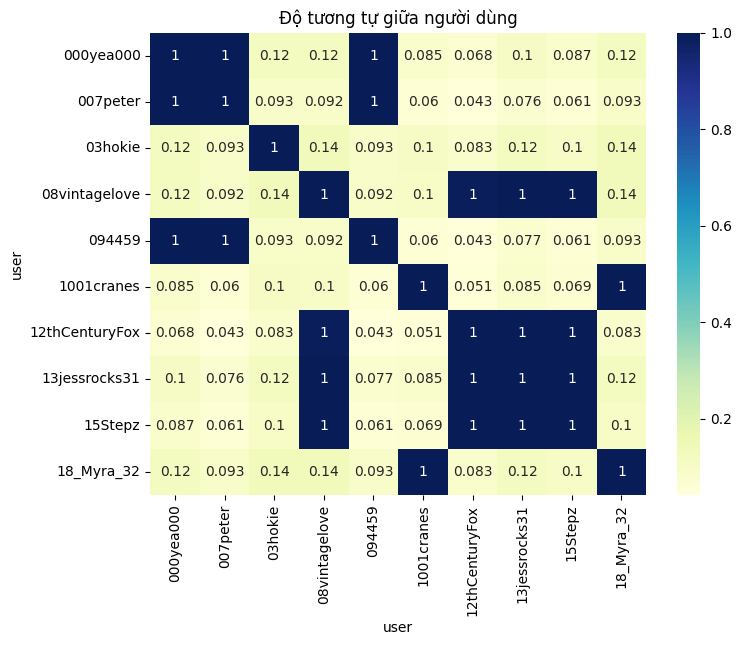

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap độ tương tự
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df.iloc[:10, :10], annot=True, cmap="YlGnBu")
plt.title("Độ tương tự giữa người dùng")
plt.show()

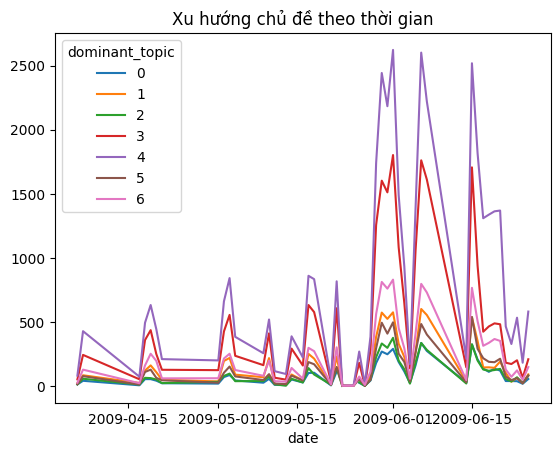

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

df["date"] = pd.to_datetime(df["date"], errors="coerce")
trend = df.groupby([df["date"].dt.date, "dominant_topic"]).size().unstack()
trend.plot()
plt.title("Xu hướng chủ đề theo thời gian")
plt.show()


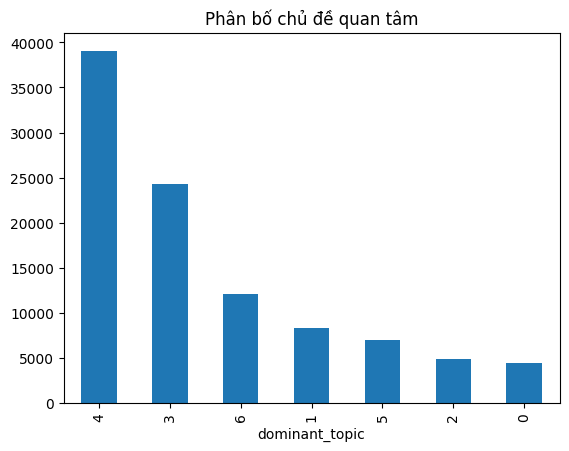

In [52]:
# Phân bố chủ đề
df["dominant_topic"].value_counts().plot(kind="bar")
plt.title("Phân bố chủ đề quan tâm")
plt.show()

7. Huấn luyện mô hình dự đoán sự quan tâm của người dùng mới

In [64]:
import joblib

# Lưu mô hình
joblib.dump(tfidf, "tfidf_model.pkl")
joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(lda_model, "lda_model.pkl")
joblib.dump(dictionary, "dictionary.pkl")
joblib.dump(svd, "svd_model.pkl")

['svd_model.pkl']